# Gonads - Somatic cells -  palantir analysis

In [1]:
import palantir
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import os
import operator
import matplotlib.pyplot as plt

import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_somatic/'
# sc.logging.print_versions()
# sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable
plt.show()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Load clustered data

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adataGC = sc.read(path_to_gonads+'FCA-gonads_somaticEarly_annotated.h5ad')
adata = sc.read(path_to_gonads+'FCA-gonads_rawcounts.h5ad')

In [3]:
adata = adata[[ i in adataGC.obs_names for i in adata.obs_names ]]

In [4]:
adataGC

AnnData object with n_obs × n_vars = 17458 × 22383
    obs: 'n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_v2', 'leiden', 'leiden_R', 'celltype', 'sex_celltype'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', '

In [5]:
adata.obsm['X_umap'] = adataGC.obsm['X_umap']
adata.obsm['X_scVI'] = adataGC.obsm['X_scVI']
adata.obsp['connectivities'] = adataGC.obsp['connectivities']
adata.obsp['distances'] = adataGC.obsp['distances']
adata.uns['celltype_colors'] = adataGC.uns['celltype_colors']
adata.uns['neighbors'] = adataGC.uns['neighbors']

## Filter early somatic cells

In [6]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'FCA-gonads_somaticEarly_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()


cell_annot = metaF['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')
adata.obs['celltype'].value_counts()

/home/jovyan/my-conda-envs/palantir/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (29,30,31,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


CoelEpi_GATA2           2805
early_somatic           2712
CoelEpi_LHX9            2181
early_supporting        1892
Gi                      1769
early_sPAX8             1717
CoelEpi_LHX9_cycling    1607
preGC_I                  921
lowQC                    799
cont                     700
Doublet                  270
Sertoli                   85
Name: celltype, dtype: int64

In [7]:
sc.pp.filter_cells(adata, min_genes=2000)

filtered out 1381 cells that have less than 2000 genes expressed


In [8]:
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype ]]
adata = adata[[ i not in ['lowQC', 'cont', 'Doublet', 'CoelEpi_LHX9_cycling'] for i in adata.obs.celltype ]]
# adata = adata[[ i not in ['Gi'] for i in adata.obs.phase ]]
adata.obs['celltype'].value_counts()

CoelEpi_GATA2       2686
early_somatic       2527
CoelEpi_LHX9        2052
early_supporting    1859
Gi                  1610
early_sPAX8         1482
preGC_I              832
Sertoli               83
Name: celltype, dtype: int64

In [9]:
# clean females in sertoli
mask1 = np.array([i in 'Sertoli' for i in adata.obs['celltype']])
mask2 = np.array(['female' in i for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata = adata[[not i for i in mask]]
adata.obs['celltype'].value_counts()

CoelEpi_GATA2       2686
early_somatic       2527
CoelEpi_LHX9        2052
early_supporting    1859
Gi                  1610
early_sPAX8         1482
preGC_I              832
Sertoli               69
Name: celltype, dtype: int64

In [10]:
# clean males in preGC_I
mask1 = np.array([i in 'preGC_I' for i in adata.obs['celltype']])
mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata = adata[[not i for i in mask]]
adata.obs['celltype'].value_counts()

CoelEpi_GATA2       2686
early_somatic       2527
CoelEpi_LHX9        2052
early_supporting    1859
Gi                  1610
early_sPAX8         1482
preGC_I              803
Sertoli               69
Name: celltype, dtype: int64

In [11]:
# even male/female pre-supportin
adata.obs['celltype2'] = adata.obs['celltype'].tolist()
mask1 = np.array([i in 'early_supporting' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_supporting_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_supporting_male'

Trying to set attribute `.obs` of view, copying.


In [12]:
# even male/female CoelEpi_LHX9
mask1 = np.array([i in 'CoelEpi_LHX9' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'CoelEpi_LHX9_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'CoelEpi_LHX9_male'
adata.obs['celltype2'].value_counts()

CoelEpi_GATA2              2686
early_somatic              2527
CoelEpi_LHX9_female        1955
early_supporting_female    1710
Gi                         1610
early_sPAX8                1482
preGC_I                     803
early_supporting_male       149
CoelEpi_LHX9_male            97
Sertoli                      69
Name: celltype2, dtype: int64

In [13]:
# even male/female early_somatic

mask1 = np.array([i in 'early_somatic' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_somatic_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_somatic_male'

In [14]:
# even male/female early_somatic

mask1 = np.array([i in 'early_sPAX8' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_sPAX8_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_sPAX8_male'

In [15]:
# even male/female early_somatic

mask1 = np.array([i in 'Gi' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'Gi_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'Gi_male'

In [16]:
print(pd.__version__)

1.1.5


... storing 'celltype2' as categorical
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


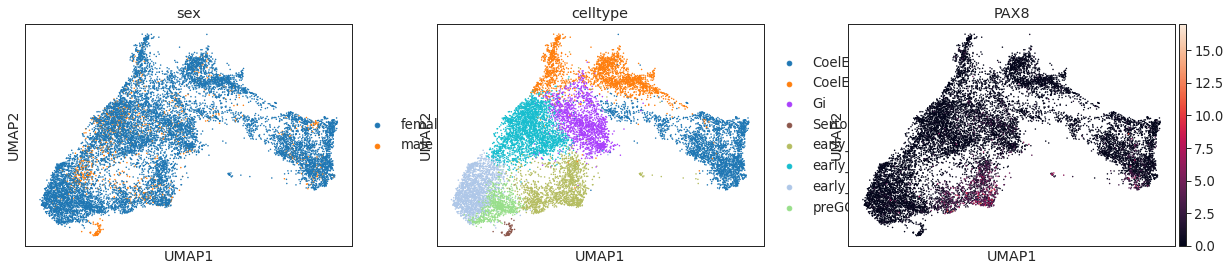

In [17]:
%matplotlib inline
sc.pl.umap(adata, color=['sex', 'celltype', 'PAX8'])

## Downsample

In [18]:
target_cells = 150
half_target_cells = n_obs=target_cells/2

adata.obs['cell'] = adata.obs.index
adata.obs['sex_fake'] = [ '--'+str(i)+'--' for i in adata.obs['celltype2'].tolist() ] # this is ensure perfect match
adata.obs['sex_fake'] = adata.obs['sex_fake'].astype('category')
#adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)

adatas = [adata[adata.obs['sex_fake'].isin([cl])] for cl in adata.obs['sex_fake'].cat.categories]

for dat in adatas:
    celltype = dat.obs.celltype[0]
    if 'early' in celltype or 'Gi' in celltype or 'CoelEpi_LHX9' in celltype: # if erly supporting, take half of each sex
        if dat.n_obs > half_target_cells:
            sc.pp.subsample(dat, n_obs=int(half_target_cells), random_state=0)
    else:
        if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])

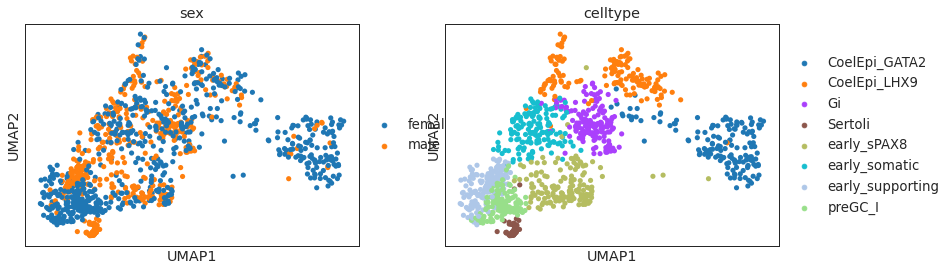

In [19]:
adata = adata[[ i in adata_downsampled.obs.cell.tolist() for i in adata.obs['cell'] ]]
adata
sc.pl.umap(adata, color=['sex', 'celltype'])

In [20]:
adata.obs['celltype2'].value_counts()

preGC_I                    150
CoelEpi_GATA2              150
early_supporting_male       75
early_supporting_female     75
early_somatic_male          75
early_somatic_female        75
early_sPAX8_male            75
early_sPAX8_female          75
Gi_male                     75
Gi_female                   75
CoelEpi_LHX9_male           75
CoelEpi_LHX9_female         75
Sertoli                     69
Name: celltype2, dtype: int64

## Find root cell

In [21]:
index, value = max(enumerate(adata[:,'UPK3B'].X), key=operator.itemgetter(1))
start_cell = adata.obs.index[index]
start_cell

'HCA_F_GON10828901_TCAGATGCATAGACTC'

Trying to set attribute `.uns` of view, copying.
<ipython-input-22-5499882dabf7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][index] = 1


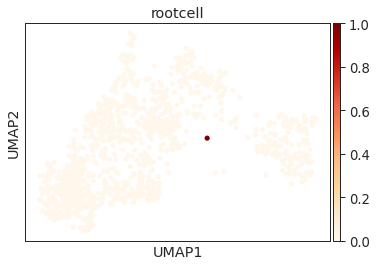

In [22]:
adata.uns['iroot'] = index
adata.obs['rootcell'] = 0
adata.obs['rootcell'][index] = 1

sc.pl.umap(adata,color='rootcell',color_map='OrRd')

In [23]:
start_cell

'HCA_F_GON10828901_TCAGATGCATAGACTC'

## Run diffusion map
Determine the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [24]:
# sc.tl.diffmap(adata)
# sc.tl.dpt(adata, n_branchings=2, n_dcs=15)

## Run palantir

In [25]:
# ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
# pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, knn=30)
# adata.obs['palantir_pseudotime'] = pr_res.pseudotime

## Visualize

In [26]:
# sc.pl.umap(adata, color=['stage',  'sex', 'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1', 'SYCP1', 'FIGLA', 'PIWIL4', 'PIWIL4', 'percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

In [27]:
# sc.pl.diffmap(adata, color=['stage',  'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1','STRA8', 'SYCP1', 'FIGLA', 'PIWIL4','percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

## Gene expression - palantir

#### Generate the norm expression matrix

In [28]:
adata_count = adata.copy()
sc.pp.filter_genes(adata_count, min_counts=3)
sc.pp.filter_cells(adata_count, min_genes=3)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
sc.pp.highly_variable_genes(adata_count, n_top_genes=2000)

m = adata_count.X.toarray()
norm_df = pd.DataFrame(data=m, index=adata_count.obs_names, columns=adata_count.var_names)

filtered out 10945 genes that are detected in less than 3 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=1000
    finished (0:00:20)
computing PCA
    on highly variable genes
    with n_comps=366
    finished (0:00:12)
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


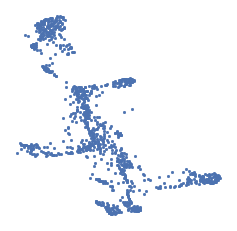

In [29]:
pca_projections, _ = palantir.utils.run_pca(adata_count)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=30)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
tsne = palantir.utils.run_tsne(ms_data)
fig, ax = palantir.plot.plot_tsne(tsne)

#### Impute with MAGIC

In [30]:
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

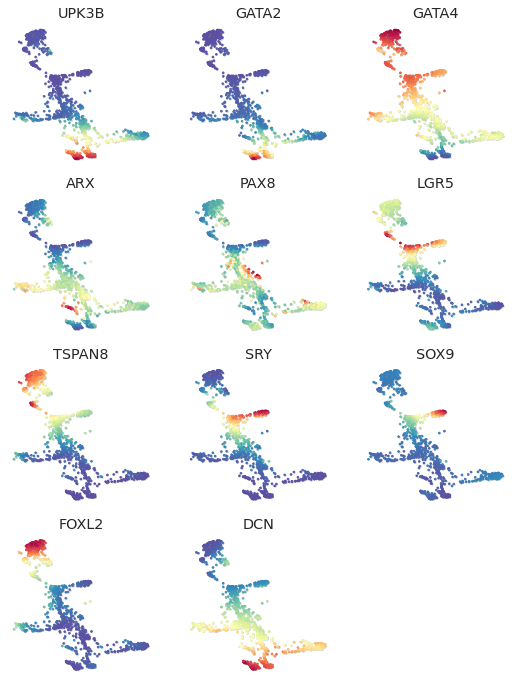

In [31]:
genes = ['UPK3B', 'GATA2', 'GATA4', 'ARX', 'PAX8', 'LGR5', 'TSPAN8', 'SRY', 'SOX9', 'FOXL2', 'DCN']
palantir.plot.plot_gene_expression(imp_df, tsne, genes, n_cols=3)
fig = plt.gcf()
fig.savefig('plot_gene_expression.pdf', dpi=1200)

#### Run diffusion

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


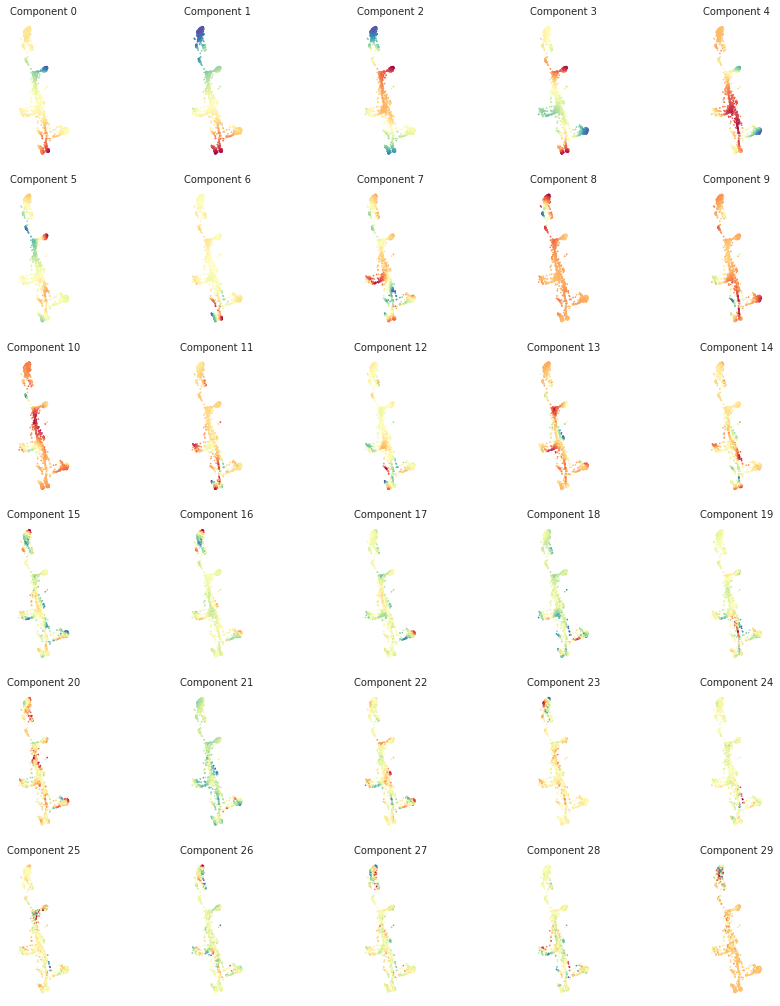

In [32]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

#### Rename terminal states to reflect the known biology below

In [33]:
start_cell

'HCA_F_GON10828901_TCAGATGCATAGACTC'

In [34]:
# obtain pr_res object
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0007978359858194987 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.06045556863149007 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9847
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [35]:
pr_res.branch_probs.columns

Index(['FCA_GND8810851_GCATGTATCTTGCCGT'], dtype='object')

In [36]:
# adata.obs['branch_1'] = [i in pr_res.branch_probs.columns[0] for i in adata.obs_names ]
# adata.obs['branch_2'] = [i in pr_res.branch_probs.columns[1] for i in adata.obs_names ]
# sc.pl.umap(adata,color=['branch_1','branch_2'],color_map='OrRd')
# palantir.plot.highlight_cells_on_tsne(tsne, start_cell)
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[0])
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[1])

FCA_GND8810851_GCATGTATCTTGCCGT


<ipython-input-37-be04d9660218>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tarcell'][i] = 1


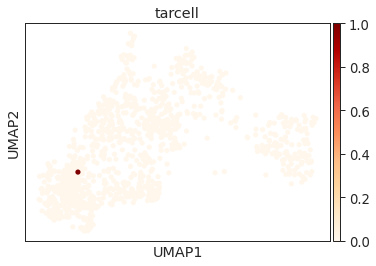

In [37]:
for i in pr_res.branch_probs.columns.tolist():
    print(i)
    adata.obs['tarcell'] = 0
    adata.obs['tarcell'][i] = 1
    sc.pl.umap(adata,color='tarcell',color_map='OrRd')

In [38]:
# mapping = pd.Series(index=['pre_spematogonia', 'oocyte'])
# mapping['oocyte'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
# mapping['pre_spematogonia'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
# #mapping['PGC'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
# #mapping['PGC'] = pr_res.branch_probs.columns.difference(mapping.values)
# mapping = pd.Series(mapping.index, index=mapping)
# mapping

In [39]:
# pr_res.branch_probs.columns = mapping
# pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Oocyte', 'Spermatocyte']]
# pr_res.branch_probs.head()

In [40]:
# palantir.plot.plot_palantir_results(pr_res, tsne)
# fig = plt.gcf()
# fig.savefig('figures_somatic/plot_palantir_results.pdf', dpi=1200)

## Gene expression trends

In [41]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

FCA_GND8810851_GCATGTATCTTGCCGT
Time for processing FCA_GND8810851_GCATGTATCTTGCCGT: 0.05780421098073323 minutes


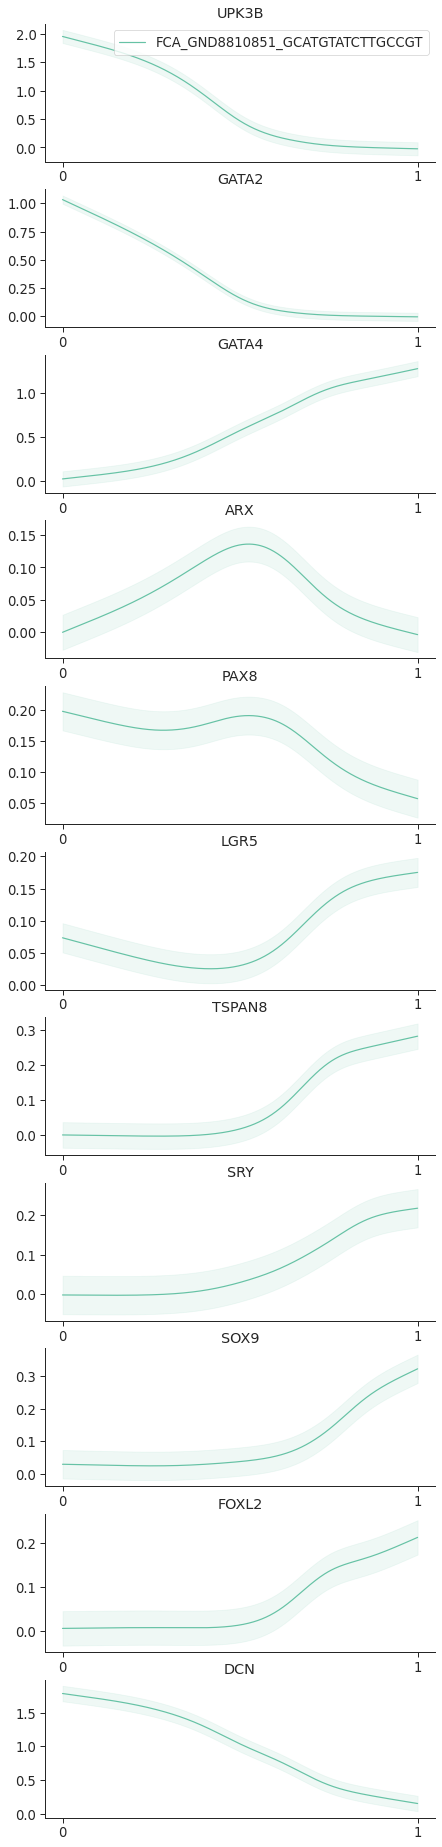

In [42]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

## Run palantir especifing endpoint as well

In [43]:
index, value = max(enumerate(adata[:,'UPK3B'].X), key=operator.itemgetter(1))
coelepiGATA2 = adata.obs.index[index]
coelepiGATA2


index, value = max(enumerate(adata[:,'SRY'].X), key=operator.itemgetter(1))
sertoli = adata.obs.index[index]
sertoli


index, value = max(enumerate(adata[:,'FOXL2'].X), key=operator.itemgetter(1))
granulosa = adata.obs.index[index]
granulosa


index, value = max(enumerate(adata[:,'PAX8'].X), key=operator.itemgetter(1))
sPAX8 = adata.obs.index[index]
sPAX8


index, value = max(enumerate(adata[:,'DCN'].X), key=operator.itemgetter(1))
Gi = adata.obs.index[index]
Gi



'HCA_F_GON10828901_TTCTCCTCACGCATCG'

In [44]:
terminal_states = pd.Series(['sertoli', 'granulosa', 'sPAX8', 'Gi'], index=[ sertoli, granulosa, sPAX8, Gi])
pr_res = palantir.core.run_palantir(ms_data, coelepiGATA2, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0006836692492167155 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.06209398508071899 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9845
Correlation at iteration 2: 0.9994
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [45]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

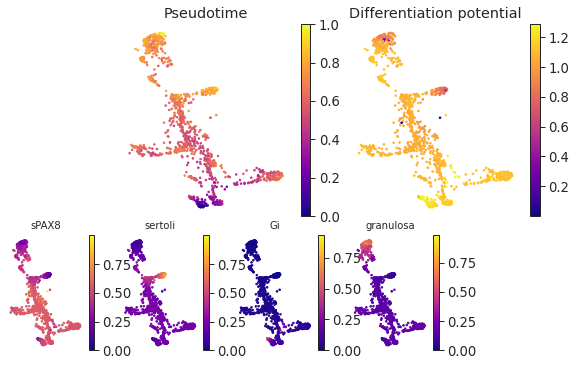

In [46]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_resultsEndpoint.pdf', dpi=1200)

In [47]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

sPAX8
Time for processing sPAX8: 0.06063214937845866 minutes
sertoli
Time for processing sertoli: 0.009744087855021158 minutes
Gi
Time for processing Gi: 0.009750258922576905 minutes
granulosa
Time for processing granulosa: 0.010029828548431397 minutes


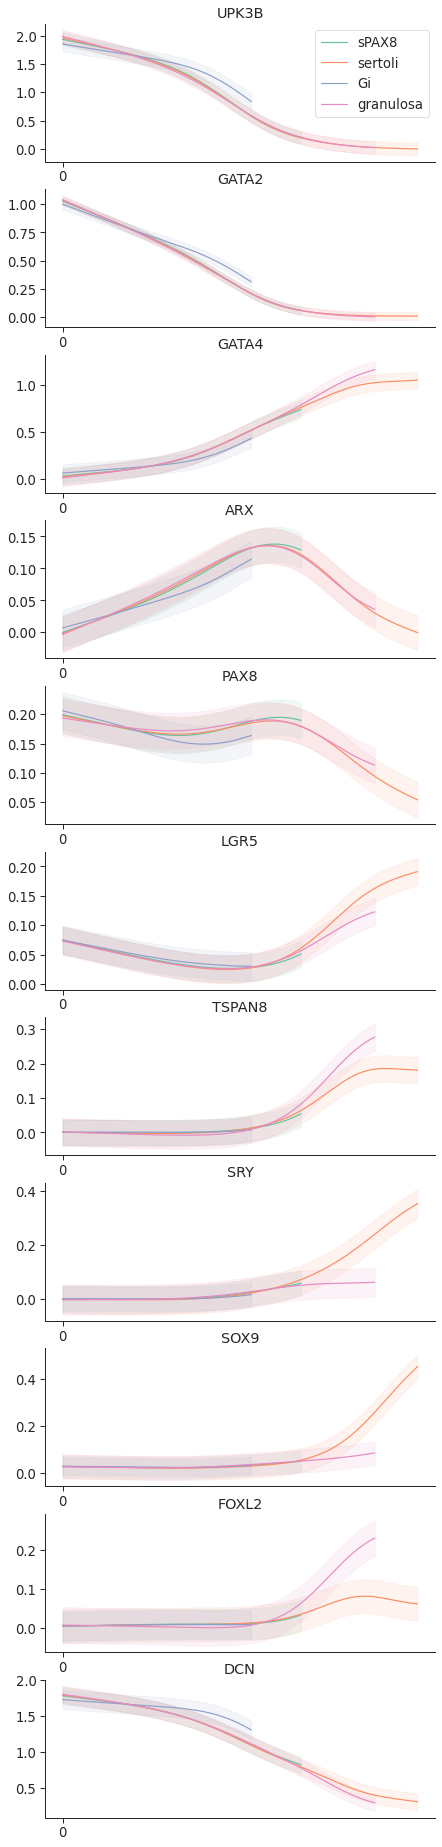

In [48]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

# Clustering

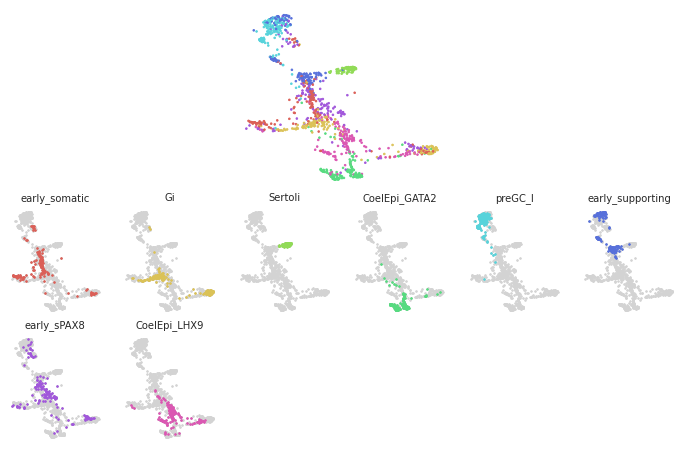

In [49]:
# clusters = palantir.utils.determine_cell_clusters(pca_projections, k=10)
clusters = adata.obs['celltype']
palantir.plot.plot_cell_clusters(tsne, clusters)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_celltypes.pdf', dpi=1200)

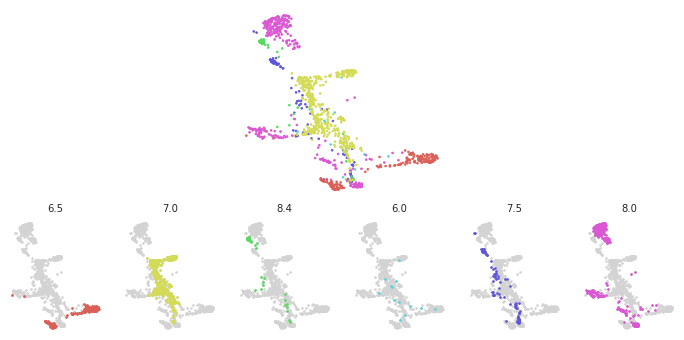

In [50]:
# clusters = palantir.utils.determine_cell_clusters(pca_projections, k=10)
PCW = adata.obs['PCW']
palantir.plot.plot_cell_clusters(tsne, PCW)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_pcw.pdf', dpi=1200)

In [51]:
adata.write('trj_palantir1_somatic.h5ad')

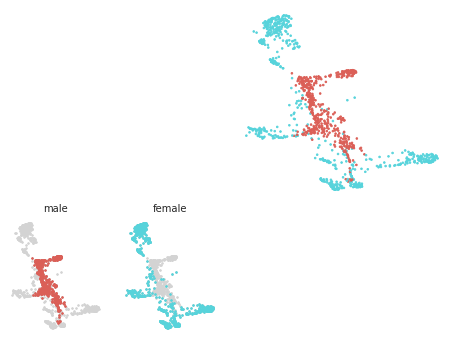

In [52]:
sex = adata.obs['sex']
palantir.plot.plot_cell_clusters(tsne, sex)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_sex.pdf', dpi=1200)